<a href="https://colab.research.google.com/github/chandagrover/AI-De-Novo-Molecule-Design/blob/master/4WithoutProperty_SMILEVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basic Installs and Imports**

In [1]:
# 10 tricks for a better Google Colab experience
# https://towardsdatascience.com/10-tips-for-a-better-google-colab-experience-33f8fe721b82
# %load_ext google.colab.data_table

In [1]:
# !pip install keras==2.2.4
%tensorflow_version 1.x
import keras
import tensorflow as tf
print("Keras: %s"%keras.__version__)
print("Tensorflow: %s"%tf.__version__)


TensorFlow 1.x selected.


Using TensorFlow backend.


Keras: 2.3.1
Tensorflow: 1.15.2


In [2]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')


--2021-01-06 04:14:26--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2021-01-06 04:14:26--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | failed with initial 

In [3]:
!sudo apt-get install software-properties-common
!sudo add-apt-repository ppa:ubuntu-toolchain-r/test
!sudo apt-get update
!sudo apt-get install gcc-4.9
!sudo apt-get upgrade libstdc++6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
software-properties-common is already the newest version (0.96.24.32.14).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.
 Toolchain test builds; see https://wiki.ubuntu.com/ToolChain

 More info: https://launchpad.net/~ubuntu-toolchain-r/+archive/ubuntu/test
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x

In [5]:
# !strings /usr/lib/x86_64-linux-gnu/libstdc++.so.6 | grep GLIBCXX

In [4]:
# General Imports
import os
import pandas as pd
import numpy as np
import sklearn
import rdkit

from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import re
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

# FOR VAE Architecture 
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import layers
from tensorflow.keras.models import load_model


print("RDKit: %s"%rdkit.__version__)



RDKit: 2020.09.3


In [5]:
# Checking if GPU is enabled or not
tf.test.gpu_device_name()

'/device:GPU:0'

# **Data Fetching**

In [6]:
# mount Google Drive
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [50]:
WEIGHTS_FOLDER = 'sample_data/weights/'
import csv
# smifile ='/drive/My Drive/ZINC/Data/ZINC_Data/SMILEWithProp.csv'      #"sample_data/SMILEWithoutProp.csv"
# data = pd.read_csv(smifile, delimiter = ",", header='infer', encoding='utf-8')
smifile ='/drive/My Drive/ZINC/Data/ZINC_Data/AAAA.smi'      
data = pd.read_csv(smifile, delimiter = " ", header='infer', encoding='utf-8')
data.smiles = data.smiles.replace('\n','', regex=True)
NUM_SMILES = len(data)
data.head()

,smiles,zinc_id
0,Cn1cnc2c1c(=O)n(C)c(=O)n2C,ZINC000000001084
1,O=C(O)[C@@H]1/C(=C/CO)O[C@@H]2CC(=O)N21,ZINC000000001169
2,Cn1c2nncnc2c(=O)n(C)c1=O,ZINC000000001447
3,Cn1cnc2c1c(=O)[nH]c(=O)n2C,ZINC000000002151
4,NC(=O)c1ncc[nH]c1=O,ZINC000000008657


In [51]:
from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(data, test_size=0.2, shuffle=False)
print(smiles_train.shape)
print(smiles_test.shape)
print(NUM_SMILES)

(3032, 2)
(759, 2)
3791


In [11]:
# logP_train = smiles_train['logP']
# logP_test = smiles_test['logP']

# qed_train=smiles_train['qed']
# qed_test=smiles_test['qed']

# SAS_train=smiles_train['SAS']
# SAS_test=smiles_test['SAS']

# train=np.array([SAS_train])   #logP_train, qed_train, SAS_train
# test= np.array([SAS_test])             #logP_test, qed_test, SAS_test
# y_train_property=train.transpose()
# y_test_property=test.transpose()

In [12]:
#Labels for the Smiles String. We will deal with three properties values.
# print(type(y_train_property))
# print(type(y_test_property))
# print(y_train_property.shape)
# print(y_test_property.shape)

### **Vector Representation of Data**

In [52]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
# embed = max([len(smile) for smile in data.smiles]) + 5
embed = max([len(smile) for smile in data.smiles])+2
# print(char_to_int)
print(int_to_char)
print(len(charset), embed)
# print(embed)

{0: '\\', 1: 'O', 2: '3', 3: 'C', 4: '-', 5: '[', 6: ')', 7: 'c', 8: '+', 9: 'E', 10: '2', 11: 'n', 12: '(', 13: 'N', 14: '1', 15: '/', 16: '6', 17: 'i', 18: '!', 19: 'H', 20: 'P', 21: '5', 22: 's', 23: 'o', 24: '=', 25: 'F', 26: 'B', 27: '@', 28: ']', 29: '#', 30: '4', 31: 'S'}
32 58


In [53]:
def vectorize(smiles):
        onehot_flatList=[[]]
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        print(one_hot.shape)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,:,:]

X_train= vectorize(smiles_train['smiles'].values)
X_test = vectorize(smiles_test['smiles'].values)

(3032, 58, 32)
(759, 58, 32)


### **Checking if Vectorization works!!**

O=C1NC(=O)C(O)(O)C(=O)N1


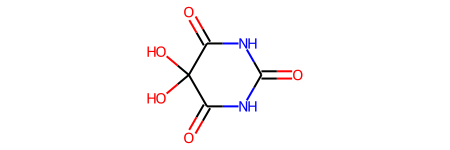

In [54]:
idx=600
print(smiles_train['smiles'][idx])
from rdkit.Chem.Draw import IPythonConsole
mol = Chem.MolFromSmiles(smiles_train['smiles'][idx])
mol

24
O=C1NC(=O)C(O)(O)C(=O)N1


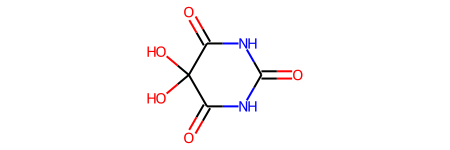

In [55]:
# Going back from vectorized form back to a readable string
smi="".join([int_to_char[idx] for idx in np.argmax(X_train[idx,:,:], axis=1)])
# String After Tructation of extra symbols
smi = re.sub('[!E]', '', smi)
print(len(smi))
print(smi)
mol = Chem.MolFromSmiles(smi)
mol

In [56]:
mol_size_x=X_train.shape[1]
mol_size_y=X_train.shape[2]
orig_dim = mol_size_x * mol_size_y
# print(mol_size_x)
# print(mol_size_y)
print(orig_dim)
X_train = np.reshape(X_train, [-1, orig_dim])
X_test = np.reshape(X_test, [-1, orig_dim])
# print(type(X_train))
# print(X_train.shape)
# print(X_train.shape[1])

1856


# **VAE**

In [57]:
# Network Parameters
INPUT_DIM=(orig_dim,)   # SMILES dimension
intermediate_dim=512
BATCH_SIZE=5
Z_DIM=2 # Dimension of the latent vector (z)
epochs=50
pre_trained=False

### **Encoder**

In [58]:
# ENCODER
def build_vae_encoder(input_dim, output_dim):
  
  # Clear tensorflow session to reset layer
  global K
  K.clear_session()
  
  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  
  #Intermediate layer
  x = Dense(intermediate_dim,activation='relu', name='hidden')(encoder_input)
 
  #Model Output
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   
  
  # Using a Keras Lambda Layer to include the sampling function as a layer in the model
  encoder_output = Lambda(sampling, output_shape=(2,), name='encoder_output')([mean_mu, log_var])

  return encoder_input, encoder_output, mean_mu, log_var, Model(encoder_input, encoder_output, name='encoder')



### **Decoder**

In [59]:
# Decoder
def build_decoder(input_dim, output_dim):

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')
  
  #Intermediate Layer
  x = Dense(intermediate_dim, activation='relu', name='hidden')(decoder_input)

    # Define model output
  decoder_output = Dense(output_dim, activation='sigmoid', name='decoder_lastlayer')(x)


  return decoder_input, decoder_output, Model(decoder_input, decoder_output, name='decoder')




### **Predictor**

In [21]:
# def create_predictor_linear():
#     '''
#     Creates a regressor that estimates property values 
#     from latent variables.
#     '''
#     predictor_input = layers.Input(shape=(Z_DIM,), name='predictor_input', dtype='float32')
    
#     x = layers.Dense(10, activation='relu', name='hidden')(predictor_input)
#     x = layers.Dense(1, activation='linear', name='predictor_lastlayer', dtype='float32')(x)
#     return Model(predictor_input, x, name='predictor')


### **Creating the OverAll Model**

In [60]:
# Model Creation 
def create_model():

  #Creating Encoder
  vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,                                                                                         output_dim = Z_DIM)
# vae_encoder.summary()
  
  
  #Creating Decoder
  vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM, output_dim=orig_dim)
# vae_decoder.summary()

  # #Creating the Predictor
  # predictor = create_predictor_linear()
  # t_predicted = predictor(mean_mu)
  


  #Creating the VAE Model 
  vae_input = vae_encoder_input

  # Output will be the output of the decoder. The term - decoder(encoder_output) 
  vae_output = vae_decoder(vae_encoder_output)

  # # VAE Model with Predictor
  # vae_predictor = Model(vae_input, [vae_output,t_predicted], name='VAE_with_Predictor')
# VAE Model without Property Predictor
  vae_without_predictor = Model(vae_input, vae_output, name='VAE_without_Predictor')



  return vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_encoder, vae_decoder_input, vae_decoder_output, vae_decoder, vae_input, vae_output, vae_without_predictor

#Creating the overall Model
encoder_input, encoder_output,  mean_mu, log_var, encoder, decoder_input, decoder_output, decoder, vae_input, vae_output, vae_without_predictor = create_model()



### **VAE Loss Function**

In [61]:
#VAE Loss Function
def vae_loss(vae_input, vae_output):
  reconstruction_loss = binary_crossentropy(vae_input, vae_output)
  reconstruction_loss = reconstruction_loss * orig_dim
    
  kl_loss = 1 + log_var - K.square(mean_mu) - K.exp(log_var)
  kl_loss = K.sum(kl_loss, axis=-1)    
  kl_loss = kl_loss * -0.5
  kl_weight=0.5
  reconst_weight=0.5
    
  # vae_loss_val = K.mean(reconstruction_loss + kl_loss)
  vae_loss_val=kl_weight * kl_loss + reconst_weight * reconstruction_loss
  return vae_loss_val


**Plotting all models**

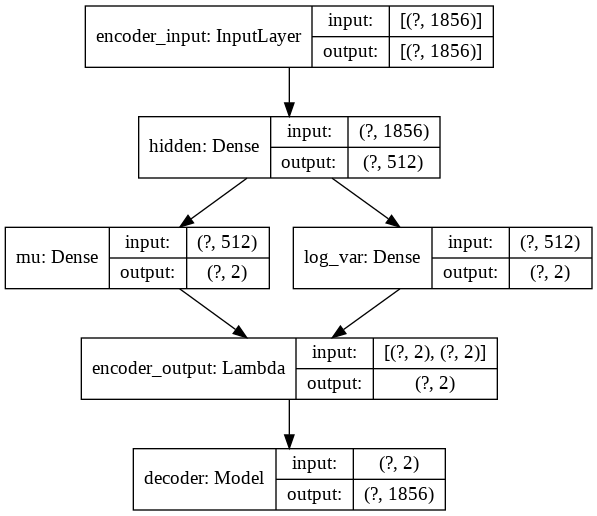

In [62]:
# Plot the Encoder Model
plot_model(encoder, to_file='/drive/My Drive/ZINC/Models/WithoutProperty/Diagram/only_encoder.png', show_shapes=True, show_layer_names=True)  #, expand_nested=True

# Plot the Decoder Model
plot_model(decoder, to_file='/drive/My Drive/ZINC/Models/WithoutProperty/Diagram/only_decoder.png', show_shapes=True, show_layer_names=True)    #, expand_nested=True

# #Plot the Predictor Model
# plot_model(predictor, to_file='/drive/My Drive/ZINC/Models/WithoutProperty/Diagram/only_predictor.png', show_shapes=True, show_layer_names=True)    #, expand_nested=True

# Plot the VAE-Predictor Model
plot_model(vae_without_predictor, to_file='/drive/My Drive/ZINC/Models/WithoutProperty/Diagram/smilesvae_without_predictor.png', show_shapes=True, show_layer_names=True)   #, expand_nested=False

# plot_model(vae_model, to_file='smilesvae_model.png', show_shapes=True, show_layer_names=True)   #, expand_nested=False

**Checkpoint**

In [63]:
# Creating Model Checkpoint for training...

checkpoint_path = "/drive/My Drive/ZINC/Models/WithoutProperty/Weights/train_ckpt/cp.ckpt"
new_check_path="/drive/My Drive/ZINC/Models/WithoutProperty/Weights/VAE_Without_Predictor{epoch:02d}-{val_loss:.2f}.h5"           #'VAE_Predictor{epoch:02d}.h5'
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=new_check_path, verbose=1, save_weights_only=False, save_best_only=True)   #, save_freq=5

# Loading weights from the latest checkpoints
#get the latest checkpoint file
checkpoint_dir = os.path.dirname(new_check_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)

### **Training or Loading the VAE-Predictor Model**

In [64]:
pre_trained=False
epochs=100
if __name__ == '__main__':          
#     Train the Variational AutoEncoder
    if pre_trained==False:
      vae_without_predictor.compile(optimizer='adam', 
                      loss=[vae_loss]) 
      history = vae_without_predictor.fit(x=X_train,
                            y=[X_train], 
                            epochs=epochs,
                            validation_data=(X_test, [X_test]),
                            verbose=2,
                            callbacks=[cp_callback] )  
      vae_without_predictor.save(new_check_path)
    else:
      vae_without_predictor.load_weights(new_check_path)
      history = vae_without_predictor.fit(x=X_train,
                            y=[X_train], 
                            epochs=epochs,
                            validation_data=(X_test, [X_test]),
                            verbose=2,
                            callbacks=[cp_callback]) 
      vae_without_predictor.save(new_check_path)
    

Train on 3032 samples, validate on 759 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 63.72771, saving model to /drive/My Drive/ZINC/Models/WithoutProperty/Weights/VAE_Without_Predictor01-63.73.h5
3032/3032 - 1s - loss: 136.1600 - val_loss: 63.7277
Epoch 2/100

Epoch 00002: val_loss improved from 63.72771 to 53.03930, saving model to /drive/My Drive/ZINC/Models/WithoutProperty/Weights/VAE_Without_Predictor02-53.04.h5
3032/3032 - 0s - loss: 52.5379 - val_loss: 53.0393
Epoch 3/100

Epoch 00003: val_loss improved from 53.03930 to 49.90219, saving model to /drive/My Drive/ZINC/Models/WithoutProperty/Weights/VAE_Without_Predictor03-49.90.h5
3032/3032 - 0s - loss: 46.2764 - val_loss: 49.9022
Epoch 4/100

Epoch 00004: val_loss improved from 49.90219 to 48.26309, saving model to /drive/My Drive/ZINC/Models/WithoutProperty/Weights/VAE_Without_Predictor04-48.26.h5
3032/3032 - 0s - loss: 43.9616 - val_loss: 48.2631
Epoch 5/100

Epoch 00005: val_loss improved from 48.26309 to 47.3

In [24]:
# print(type(history))
# print(type(history.history))
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


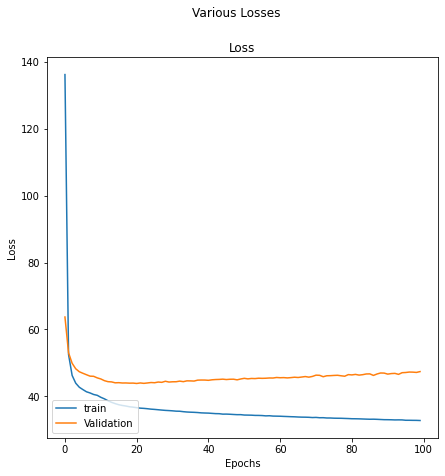

In [65]:
# summarize history for loss
fig, (ax1) = plt.subplots(1, 1, figsize=(7,7))
fig.suptitle('Various Losses')


ax1.plot(history.history['loss'])
ax1.plot( history.history['val_loss'])
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(['train', 'Validation'], loc='lower left')


# ax2.plot(history.history['decoder_loss'])
# ax2.plot(history.history['val_decoder_loss'])
# ax2.set_title('Decoder Loss')
# ax2.set_xlabel('Epochs')
# ax2.set_ylabel('Decoder Loss')
# ax2.legend(['train', 'Validation'], loc='lower left')

# ax3.plot(history.history['predictor_loss']) 
# ax3.plot(history.history['val_predictor_loss'])
# ax3.set_title('Predictor Loss')
# ax3.set_xlabel('Epochs')
# ax3.set_ylabel('Predictor Loss')
# ax3.legend(['train', 'Validation'], loc='lower left')

# **Latent Space Visualization**

### **Each Component of latent space**

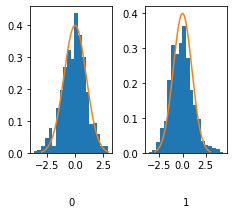

In [66]:
from scipy.stats import norm
# with graph.as_default():   # We are using this statement to reuse the last saved trained model
z_test = encoder.predict(X_test)

x = np.linspace(-3, 3, 300)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(2):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('on')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

In [30]:
# from sklearn.manifold import TSNE
# z_mean = encoder.predict(X_test)
# # print(z_mean)
# model_name='VAESMILES_Latent'
# os.makedirs(model_name, exist_ok=True)
# filename = os.path.join(model_name, "smilesvae_mean.png")

# # z_embedded = TSNE(n_components=2).fit_transform(z_mean)
# plt.figure(figsize=(7,7))
# plt.scatter(z_mean[:, 0], z_mean[:, 1], c=SAS_test)
# plt.colorbar()
# plt.xlabel("z[0]")
# plt.ylabel("z[1]")
# plt.title('SAS on test data')
# plt.savefig(filename)
# plt.show()

# **Reconstruction**


In [31]:
# # Calculating mean and standard deviation of all property values on test data

# SAS_mean_test= np.mean(y_test_property, axis=0)
# SAS_std_test = np.std(y_test_property, axis=0)


In [67]:
# encoded, decoded and predicted data on test dataset

encoded_xtest=encoder.predict(X_test)
# predicted_xtest=predictor.predict(encoded_xtest)
decoded_xtest=decoder.predict(encoded_xtest)
print(encoded_xtest.shape)
# print(predicted_xtest.shape)
print(decoded_xtest.shape)

# Reshaping the original and reconstructed test data
orig_test=X_test.reshape(len(X_test), mol_size_x, mol_size_y)
reconst_test = decoded_xtest.reshape(len(X_test), mol_size_x,mol_size_y)
print(orig_test.shape)
print(reconst_test.shape)

(759, 2)
(759, 1856)
(759, 58, 32)
(759, 58, 32)


### **Reconstruction and Prediction on Original test data set**

759 Original Valid Test Samples


/usr/local/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


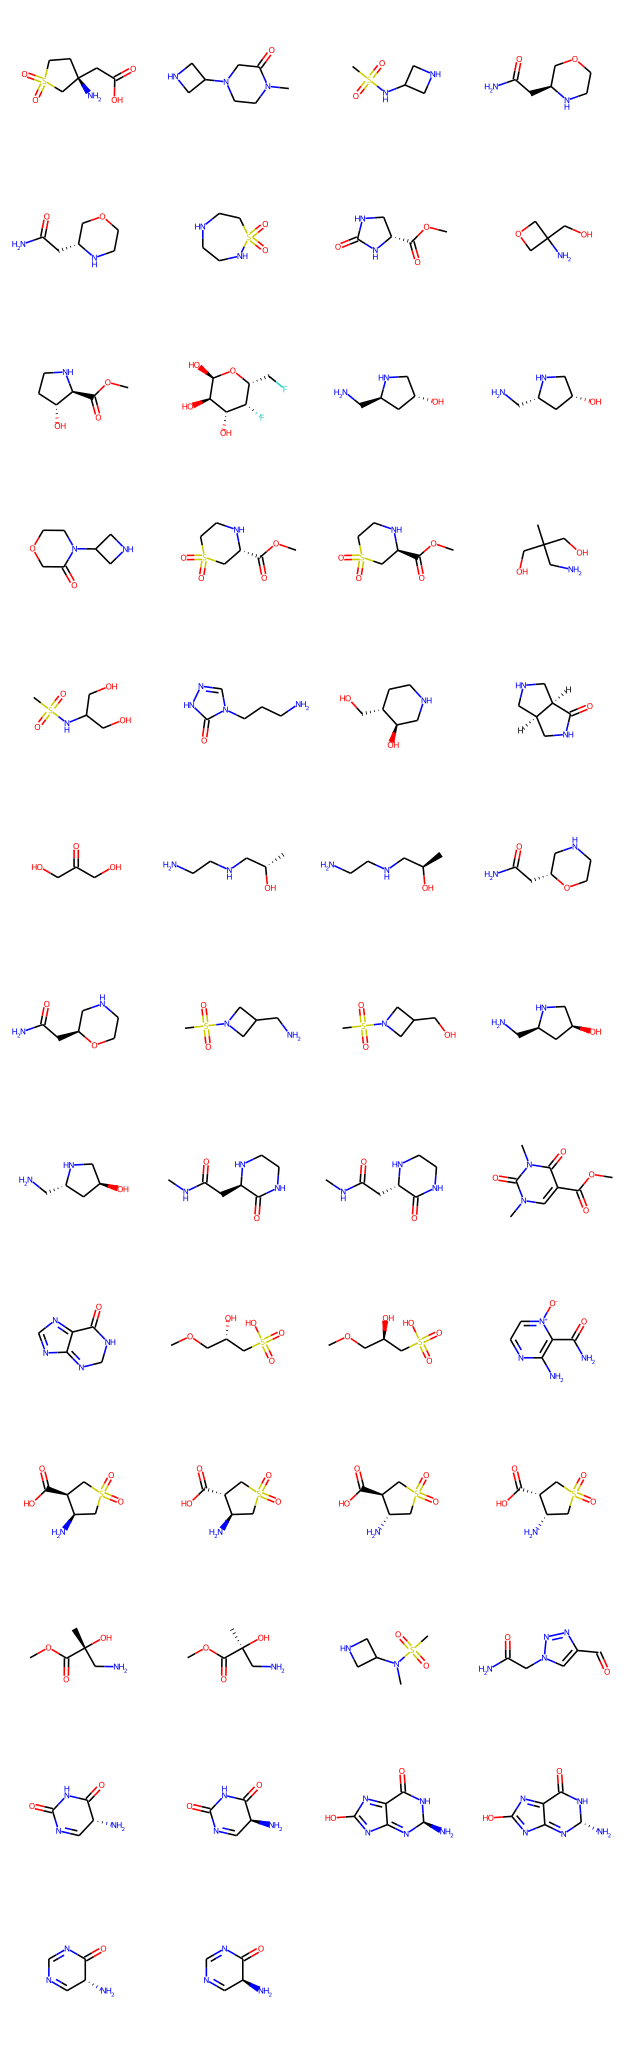

In [68]:
# Going back from vectorized form back to a readable string on original test data
IPythonConsole.ipython_useSVG=True 
mols_orig_test= []
smi_orig_test=[]
syntax_val={0:[], 1:[]}

for id in range(len(X_test)):
  smi="".join([int_to_char[idx] for idx in np.argmax(orig_test[id,:,:], axis=1)])
  # print(len(mol))
  smi = re.sub('!|E',"", smi)
  smi_orig_test.append(smi)
  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_orig_test.append(mol)
  if mol is None:
    syntax_val[0].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t invalid SMILES", sep=' ')
    print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid SMiles" ,sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol)
      # print(mol)
    except:
      print('Mol {} {}'.format(id+1, mol)) 


smi_orig_test_valid=[]
mols_orig_test_valid=[]
for item in syntax_val[1]:
  smi_orig_test_valid.append(smi_orig_test[item])
  mols_orig_test_valid.append(mols_orig_test[item])
# smi_orig_test_valid


print(len(mols_orig_test_valid), "Original Valid Test Samples")
Draw.MolsToGridImage(mols_orig_test_valid, molsPerRow=4,subImgSize=(200,200))




### **Reconstruction and Prediction of property on reconstructed test data**


Mol 16 	 length = 13 	 NCCCCCOCCCCCO 	 Valid Reconstructed Smile
Mol 21 	 length = 9 	 NCC(CC)CO 	 Valid Reconstructed Smile
Mol 50 	 length = 16 	 N[C@@H](O)CCCC=O 	 Valid Reconstructed Smile
Mol 53 	 length = 12 	 NCC(CC)CCOCC 	 Valid Reconstructed Smile
Mol 59 	 length = 11 	 Nc1nnnnnnn1 	 Valid Reconstructed Smile
Mol 75 	 length = 12 	 CCCCCCNCCOCC 	 Valid Reconstructed Smile
Mol 149 	 length = 13 	 NCCCCCNCCOCCO 	 Valid Reconstructed Smile
Mol 152 	 length = 16 	 N[C@@H](O)CCCC=O 	 Valid Reconstructed Smile
Mol 157 	 length = 13 	 NCCCCCNCCOCCO 	 Valid Reconstructed Smile
Mol 168 	 length = 12 	 NCCCCCCCCCCO 	 Valid Reconstructed Smile
Mol 178 	 length = 19 	 C[C@@H](O)CCCCCCCCO 	 Valid Reconstructed Smile


RDKit ERROR: [04:42:34] SMILES Parse Error: syntax error while parsing: N[C@O)(CCC((O)(CC)[(())CCOO
RDKit ERROR: [04:42:34] SMILES Parse Error: Failed parsing SMILES 'N[C@O)(CCC((O)(CC)[(())CCOO' for input: 'N[C@O)(CCC((O)(CC)[(())CCOO'
RDKit ERROR: [04:42:34] SMILES Parse Error: extra close parentheses while parsing: N=C(O)CCO)C(CCCCCC
RDKit ERROR: [04:42:34] SMILES Parse Error: Failed parsing SMILES 'N=C(O)CCO)C(CCCCCC' for input: 'N=C(O)CCO)C(CCCCCC'
RDKit ERROR: [04:42:34] SMILES Parse Error: extra open parentheses for input: 'N=C(O)CCOCC(CCCO'
RDKit ERROR: [04:42:34] SMILES Parse Error: extra close parentheses while parsing: C=C(O))CC@H](CCCCC1
RDKit ERROR: [04:42:34] SMILES Parse Error: Failed parsing SMILES 'C=C(O))CC@H](CCCCC1' for input: 'C=C(O))CC@H](CCCCC1'
RDKit ERROR: [04:42:34] SMILES Parse Error: syntax error while parsing: COC(=O)CC@@]]CCCCC1
RDKit ERROR: [04:42:34] SMILES Parse Error: Failed parsing SMILES 'COC(=O)CC@@]]CCCCC1' for input: 'COC(=O)CC@@]]CCCCC1'
RDKit ER

Mol 227 	 length = 12 	 NCC(CC)CCOCO 	 Valid Reconstructed Smile
Mol 235 	 length = 18 	 COC(=O)[C@@H](O)CO 	 Valid Reconstructed Smile
Mol 253 	 length = 11 	 NCC(CC)CCOC 	 Valid Reconstructed Smile
Mol 255 	 length = 41 	 C[C@@H]1O[C@H](O)[C@H](O)[C@H](OO)[C@H]1O 	 Valid Reconstructed Smile
Mol 293 	 length = 42 	 C[C@@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@H]1OO 	 Valid Reconstructed Smile
Mol 294 	 length = 42 	 C[C@@H]1O[C@H](O)[C@@H](O)[C@H](O)[C@H]1OO 	 Valid Reconstructed Smile
Mol 296 	 length = 12 	 NCC(CC)CCOCO 	 Valid Reconstructed Smile
Mol 315 	 length = 39 	 O=C(O)[C@@H]1O[C@@H](O)[C@H](O)[C@@H]1O 	 Valid Reconstructed Smile
Mol 342 	 length = 14 	 O=C(CO)C=CCCCC 	 Valid Reconstructed Smile
Mol 348 	 length = 41 	 C[C@@H]1O[C@H](O)[C@H](O)[C@H](OO)[C@H]1O 	 Valid Reconstructed Smile
Mol 368 	 length = 15 	 N=C(O)CCOCCCCCO 	 Valid Reconstructed Smile
Mol 371 	 length = 18 	 COC(=O)[C@@H](O)CO 	 Valid Reconstructed Smile
Mol 382 	 length = 12 	 NCCCCCOCCCCO 	 Valid Reconstructed 

RDKit ERROR: [04:42:34] SMILES Parse Error: syntax error while parsing: CCCC@@H]CCCCC@@H]OO
RDKit ERROR: [04:42:34] SMILES Parse Error: Failed parsing SMILES 'CCCC@@H]CCCCC@@H]OO' for input: 'CCCC@@H]CCCCC@@H]OO'
RDKit ERROR: [04:42:34] SMILES Parse Error: syntax error while parsing: O=CC@@C@@O)C[C@H](O)[C@@H](O[[C@H](O)
RDKit ERROR: [04:42:34] SMILES Parse Error: Failed parsing SMILES 'O=CC@@C@@O)C[C@H](O)[C@@H](O[[C@H](O)' for input: 'O=CC@@C@@O)C[C@H](O)[C@@H](O[[C@H](O)'
RDKit ERROR: [04:42:34] SMILES Parse Error: syntax error while parsing: O=C(O)[C@CH](CCCCO
RDKit ERROR: [04:42:34] SMILES Parse Error: Failed parsing SMILES 'O=C(O)[C@CH](CCCCO' for input: 'O=C(O)[C@CH](CCCCO'
RDKit ERROR: [04:42:34] SMILES Parse Error: syntax error while parsing: O=C(O)[C@C](CCCCCC1
RDKit ERROR: [04:42:34] SMILES Parse Error: Failed parsing SMILES 'O=C(O)[C@C](CCCCCC1' for input: 'O=C(O)[C@C](CCCCCC1'
RDKit ERROR: [04:42:34] SMILES Parse Error: syntax error while parsing: N[C@H]((O)CCCCCCCCC
RDKit

Mol 455 	 length = 13 	 NCCCCCNCCOCCO 	 Valid Reconstructed Smile
Mol 481 	 length = 18 	 N[C@@H](O)CCCCCCCC 	 Valid Reconstructed Smile
Mol 555 	 length = 34 	 C[C@@H]1O[C@@H](O)[C@H](O)[C@@H]1O 	 Valid Reconstructed Smile
Mol 582 	 length = 41 	 C[C@@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@H]1O 	 Valid Reconstructed Smile
Mol 596 	 length = 15 	 NCCC(=O)C(CCCO) 	 Valid Reconstructed Smile
Mol 597 	 length = 5 	 NCCOC 	 Valid Reconstructed Smile
Mol 598 	 length = 7 	 NCC(CC) 	 Valid Reconstructed Smile
Mol 612 	 length = 18 	 N[C@@H](O)CCCCCCCO 	 Valid Reconstructed Smile
Mol 615 	 length = 15 	 NCC(C)CCOCCCCCO 	 Valid Reconstructed Smile
Mol 624 	 length = 13 	 NCCCCCNCCOCCO 	 Valid Reconstructed Smile
Mol 638 	 length = 41 	 C[C@@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@H]1O 	 Valid Reconstructed Smile


RDKit ERROR: [04:42:34] SMILES Parse Error: syntax error while parsing: O=CC@@H](O)C[C@H](O)[C@@]]O)[C@@H](O)
RDKit ERROR: [04:42:34] SMILES Parse Error: Failed parsing SMILES 'O=CC@@H](O)C[C@H](O)[C@@]]O)[C@@H](O)' for input: 'O=CC@@H](O)C[C@H](O)[C@@]]O)[C@@H](O)'
RDKit ERROR: [04:42:34] SMILES Parse Error: syntax error while parsing: C[C@@H]1[[@H]((O)[@@]](O)[C@H]]OO)[C@H]1O
RDKit ERROR: [04:42:34] SMILES Parse Error: Failed parsing SMILES 'C[C@@H]1[[@H]((O)[@@]](O)[C@H]]OO)[C@H]1O' for input: 'C[C@@H]1[[@H]((O)[@@]](O)[C@H]]OO)[C@H]1O'
RDKit ERROR: [04:42:34] SMILES Parse Error: extra close parentheses while parsing: Cc1ncccccnnn)cc=n)nn1
RDKit ERROR: [04:42:34] SMILES Parse Error: Failed parsing SMILES 'Cc1ncccccnnn)cc=n)nn1' for input: 'Cc1ncccccnnn)cc=n)nn1'
RDKit ERROR: [04:42:34] SMILES Parse Error: extra close parentheses while parsing: NCCCC)((O)CCCCOO
RDKit ERROR: [04:42:34] SMILES Parse Error: Failed parsing SMILES 'NCCCC)((O)CCCCOO' for input: 'NCCCC)((O)CCCCOO'
RDKit ERR

Mol 670 	 length = 19 	 C[C@@H](O)CCCCCCCCC 	 Valid Reconstructed Smile
Mol 694 	 length = 16 	 NC1nnccccnnnnnc1 	 Valid Reconstructed Smile
Mol 721 	 length = 19 	 C[C@@H](O)CCCCCCCCO 	 Valid Reconstructed Smile
Mol 759 	 length = 34 	 C[C@@H]1C[C@H](OO)[C@H](O)[C@@H]1O 	 Valid Reconstructed Smile
Original Valid CC(CN)(CO)CO
Reconstructed Valid NCCCCCOCCCCCO
Original Valid O=C(CO)CO
Reconstructed Valid NCC(CC)CO
Original Valid N[C@H]1C=NC=NC1=O
Reconstructed Valid N[C@@H](O)CCCC=O
Original Valid O=S(=O)(O)CO
Reconstructed Valid NCC(CC)CCOCC
Original Valid COCCn1nnnc1N
Reconstructed Valid Nc1nnnnnnn1
Original Valid O=C(CCO)NCCO
Reconstructed Valid CCCCCCNCCOCC
Original Valid CNC1(CO)COC1
Reconstructed Valid NCCCCCNCCOCCO
Original Valid O=C1NCNC12CCNCC2
Reconstructed Valid N[C@@H](O)CCCC=O
Original Valid O=S1(=O)NCCO1
Reconstructed Valid NCCCCCNCCOCCO
Original Valid COC1(CN)CNC1
Reconstructed Valid NCCCCCCCCCCO
Original Valid C[C@@H]1NCC(=O)NC1=O
Reconstructed Valid C[C@@H](O)CCCCCCCCO


RDKit ERROR: [04:42:35] SMILES Parse Error: syntax error while parsing: CCCC@H](CCCC@C](OCCCCC@@](OOO
RDKit ERROR: [04:42:35] SMILES Parse Error: Failed parsing SMILES 'CCCC@H](CCCC@C](OCCCCC@@](OOO' for input: 'CCCC@H](CCCC@C](OCCCCC@@](OOO'
RDKit ERROR: [04:42:35] SMILES Parse Error: syntax error while parsing: O[C@@H](CCCCCC@@O((O)CC@@((OOO
RDKit ERROR: [04:42:35] SMILES Parse Error: Failed parsing SMILES 'O[C@@H](CCCCCC@@O((O)CC@@((OOO' for input: 'O[C@@H](CCCCCC@@O((O)CC@@((OOO'
RDKit ERROR: [04:42:35] SMILES Parse Error: syntax error while parsing: O[C@@H](CCCCCC@@OC(O)CC@@(HOOO
RDKit ERROR: [04:42:35] SMILES Parse Error: Failed parsing SMILES 'O[C@@H](CCCCCC@@OC(O)CC@@(HOOO' for input: 'O[C@@H](CCCCCC@@OC(O)CC@@(HOOO'
RDKit ERROR: [04:42:35] SMILES Parse Error: syntax error while parsing: C[C@(]O[[[@H]((O[[[@]H](O)[C@])1
RDKit ERROR: [04:42:35] SMILES Parse Error: Failed parsing SMILES 'C[C@(]O[[[@H]((O[[[@]H](O)[C@])1' for input: 'C[C@(]O[[[@H]((O[[[@]H](O)[C@])1'
RDKit ERROR: 

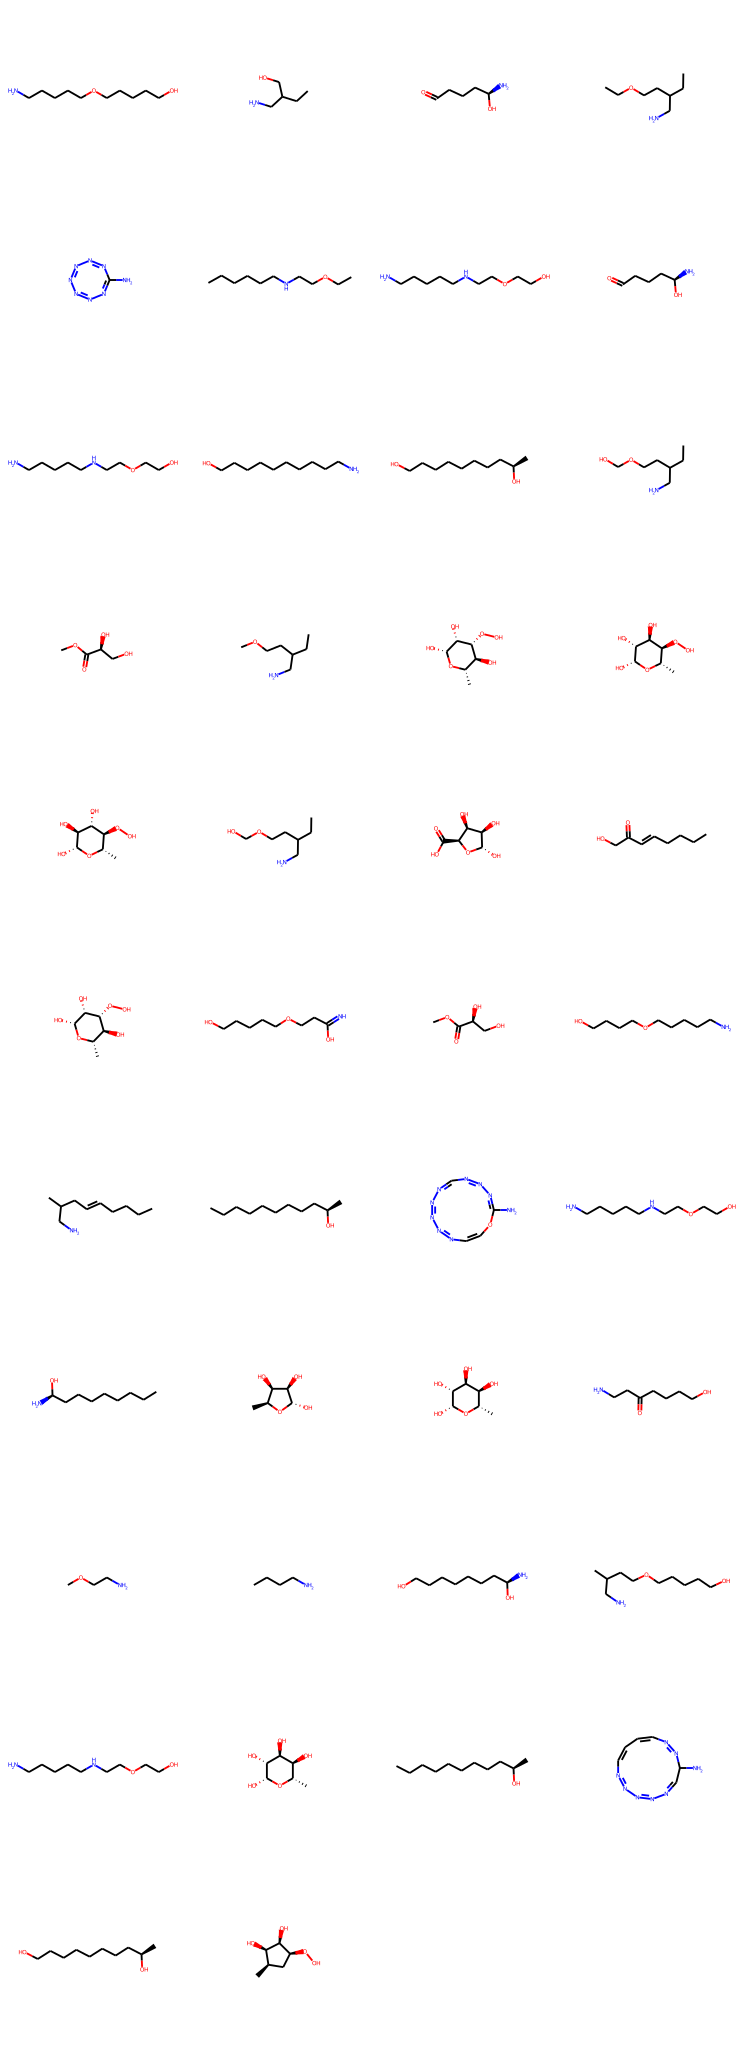

In [69]:

# Going back from vectorized form back to a readable string on original test data
#Reconstruction
syntax_val={0:[], 1:[]}
mols_reconst_test= []
smi_reconst_test=[]

for id in range(len(X_test)):
  smi="".join([int_to_char[idx] for idx in np.argmax(reconst_test[id,:,:], axis=1)])
  # print(len(mol))
  smi = re.sub('!|E',"", smi)
  smi_reconst_test.append(smi)
  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_reconst_test.append(mol)
  if mol is None:
    syntax_val[0].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t invalid SMILES", sep=' ')
    # print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val[1].append(id)
    print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid Reconstructed Smile", sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol)
    except:
      print('Mol {} {}'.format(id+1, mol)) 


smi_reconst_test_valid=[]
mols_reconst_test_valid=[]
for item in syntax_val[1]:
  smi_reconst_test_valid.append(smi_reconst_test[item])
  mols_reconst_test_valid.append(mols_reconst_test[item])
  print("Original Valid", smi_orig_test[item] )
  print("Reconstructed Valid", smi_reconst_test[item])
print(len(mols_reconst_test_valid), "Reconstructed Valid Test Samples")
Draw.MolsToGridImage(mols_reconst_test_valid, molsPerRow=4,subImgSize=(200,200))



In [70]:
# encoded, decoded and predicted data on Training dataset

encoded_xtrain=encoder.predict(X_train)
# predicted_xtest=predictor.predict(encoded_xtrain)
decoded_xtrain=decoder.predict(encoded_xtrain)
print(encoded_xtrain.shape)
# print(predicted_xtrain.shape)
print(decoded_xtrain.shape)

# Reshaping the original and reconstructed train data
orig_train=X_train.reshape(len(X_train), mol_size_x, mol_size_y)
reconst_train = decoded_xtrain.reshape(len(X_train), mol_size_x,mol_size_y)
print(orig_train.shape)
print(reconst_train.shape)

(3032, 2)
(3032, 1856)
(3032, 58, 32)
(3032, 58, 32)


In [36]:
# print(reconst_train[2][10])
# print(orig_train[2][10])

3032 Original Valid Training Samples


/usr/local/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


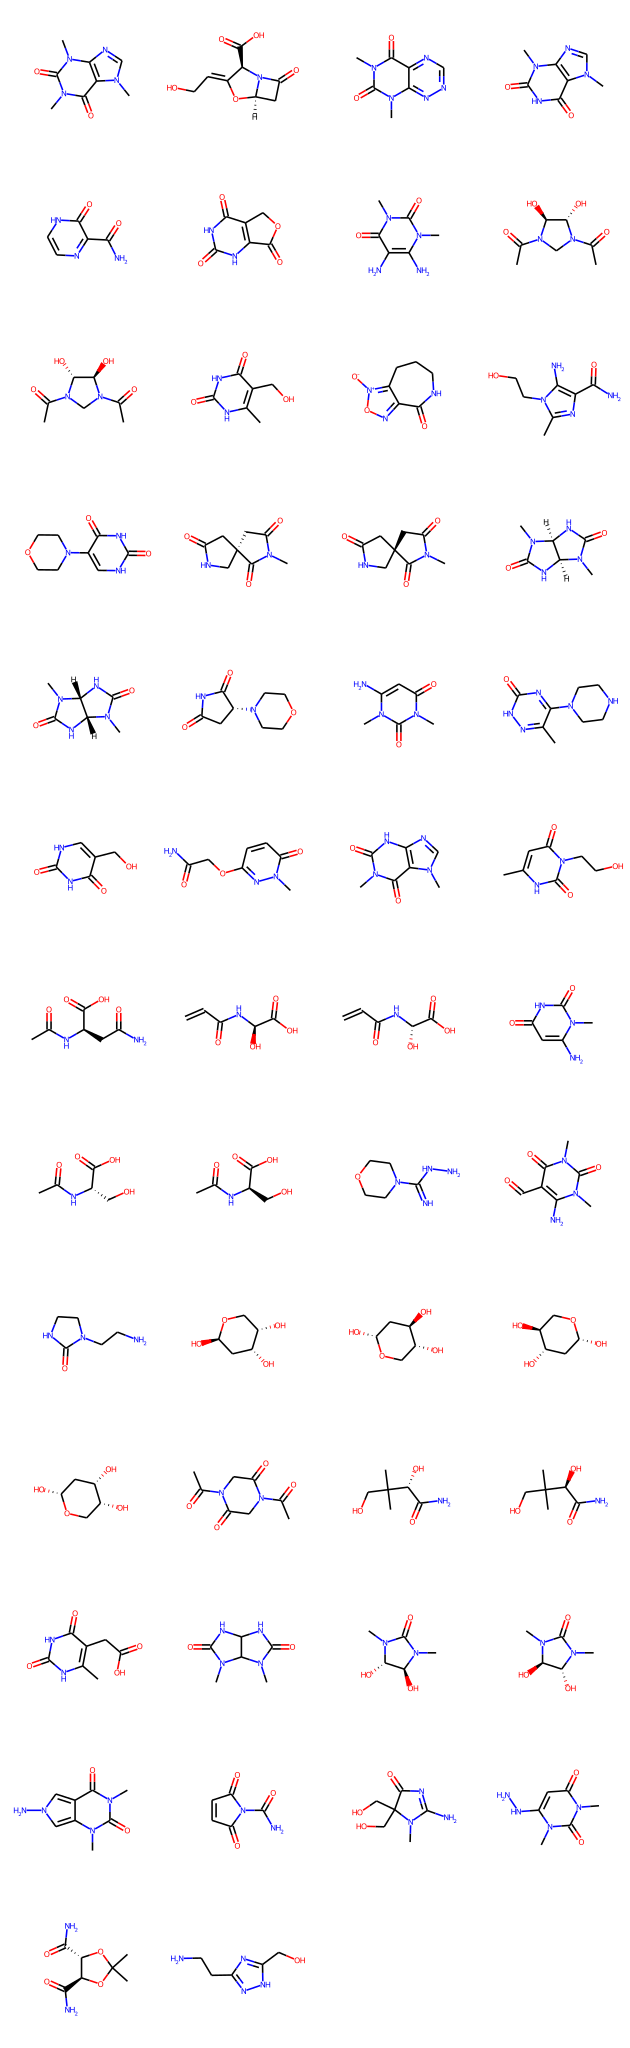

In [71]:
# Going back from vectorized form back to a readable string on original training data
#Reconstruction

syntax_val={0:[], 1:[]}
smi_orig_train=[]
smi_orig_train_valid=[]
mols_orig_train= []
mols_orig_train_valid=[]
for id in range(len(X_train)):
  smi="".join([int_to_char[idx] for idx in np.argmax(orig_train[id,:,:], axis=1)])
  # print(len(mol))
  smi = re.sub('!|E',"", smi)
  smi_orig_train.append(smi)
  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_orig_train.append(mol)
  if mol is None:
    syntax_val[0].append(id)
    # print('Mol', id+1, "\t length =",len(mol), "\t invalid SMILES", sep=' ')
    # print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid Smiles", sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol)
    except:
      print('Mol {} {}'.format(id+1, mol)) 


for item in syntax_val[1]:
  smi_orig_train_valid.append(smi_orig_train[item].rstrip('\n'))
  mols_orig_train_valid.append(mols_orig_train[item])
# smi_reconst_train_valid


print(len(mols_orig_train_valid), "Original Valid Training Samples")
Draw.MolsToGridImage(mols_orig_train_valid, molsPerRow=4,subImgSize=(200,200))



Mol 57 	 length = 15 	 N=C(O)CCOCCCCCO 	 Valid Smiles
Mol 66 	 length = 16 	 NCC(O)(CO)CCCCCO 	 Valid Smiles
Mol 68 	 length = 10 	 NCC(CC)CCO 	 Valid Smiles
Mol 72 	 length = 12 	 NCCCCCCCCCCO 	 Valid Smiles
Mol 78 	 length = 12 	 NCCCCCOCCCCO 	 Valid Smiles
Mol 117 	 length = 16 	 N[C@@H](O)CCCC=O 	 Valid Smiles
Mol 150 	 length = 34 	 O=C(O)[C@@H](O)[C@H](O)[C@@H](O)CO 	 Valid Smiles
Mol 155 	 length = 16 	 N[C@@H](O)CCCC=O 	 Valid Smiles
Mol 173 	 length = 12 	 NCCCCCOCCCCC 	 Valid Smiles
Mol 184 	 length = 42 	 C[C@@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@@H]1O 	 Valid Smiles


RDKit ERROR: [05:02:43] SMILES Parse Error: syntax error while parsing: Cn1ccncccc())c(=O))())c1=O
RDKit ERROR: [05:02:43] SMILES Parse Error: Failed parsing SMILES 'Cn1ccncccc())c(=O))())c1=O' for input: 'Cn1ccncccc())c(=O))())c1=O'
RDKit ERROR: [05:02:43] SMILES Parse Error: syntax error while parsing: O=C(O)[C@@H](O[CC@H](O)[C@@H]())CO@H]1O
RDKit ERROR: [05:02:43] SMILES Parse Error: Failed parsing SMILES 'O=C(O)[C@@H](O[CC@H](O)[C@@H]())CO@H]1O' for input: 'O=C(O)[C@@H](O[CC@H](O)[C@@H]())CO@H]1O'
RDKit ERROR: [05:02:43] SMILES Parse Error: syntax error while parsing: Cn1ccncnnnccc==))nn]c1=O
RDKit ERROR: [05:02:43] SMILES Parse Error: Failed parsing SMILES 'Cn1ccncnnnccc==))nn]c1=O' for input: 'Cn1ccncnnnccc==))nn]c1=O'
RDKit ERROR: [05:02:43] SMILES Parse Error: extra close parentheses while parsing: Cn1cccccccnn)c(=O)nnC)c1
RDKit ERROR: [05:02:43] SMILES Parse Error: Failed parsing SMILES 'Cn1cccccccnn)c(=O)nnC)c1' for input: 'Cn1cccccccnn)c(=O)nnC)c1'
RDKit ERROR: [05:02:43] SM

Mol 248 	 length = 18 	 N[C@@H](O)CCCCCCCO 	 Valid Smiles
Mol 251 	 length = 14 	 NCC(C)CCOCCCCC 	 Valid Smiles
Mol 291 	 length = 14 	 NCC(C)CCOCCCCC 	 Valid Smiles
Mol 295 	 length = 34 	 C[C@@H]1C[C@H](OO)[C@H](O)[C@@H]1O 	 Valid Smiles
Mol 352 	 length = 34 	 C[C@@H]1C[C@H](OO)[C@H](O)[C@@H]1O 	 Valid Smiles
Mol 353 	 length = 41 	 C[C@@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@H]1O 	 Valid Smiles
Mol 377 	 length = 14 	 O=C(CO)C=CCCCC 	 Valid Smiles
Mol 409 	 length = 14 	 NCC(C)CC=CCCCC 	 Valid Smiles
Mol 418 	 length = 12 	 NCCCCCNCCOCC 	 Valid Smiles
Mol 446 	 length = 15 	 N=C(O)CCOCCCCCO 	 Valid Smiles


RDKit ERROR: [05:02:43] SMILES Parse Error: syntax error while parsing: CCCC@@H)CCCCCC@H]OOO
RDKit ERROR: [05:02:43] SMILES Parse Error: Failed parsing SMILES 'CCCC@@H)CCCCCC@H]OOO' for input: 'CCCC@@H)CCCCCC@H]OOO'
RDKit ERROR: [05:02:43] SMILES Parse Error: extra close parentheses while parsing: Cc1nccccccnn)c(=n)nnO1
RDKit ERROR: [05:02:43] SMILES Parse Error: Failed parsing SMILES 'Cc1nccccccnn)c(=n)nnO1' for input: 'Cc1nccccccnn)c(=n)nnO1'
RDKit ERROR: [05:02:43] SMILES Parse Error: unclosed ring for input: 'Nc1nnnnnnn'
RDKit ERROR: [05:02:43] SMILES Parse Error: syntax error while parsing: NCCC@@]]CCCCCC
RDKit ERROR: [05:02:43] SMILES Parse Error: Failed parsing SMILES 'NCCC@@]]CCCCCC' for input: 'NCCC@@]]CCCCCC'
RDKit ERROR: [05:02:43] SMILES Parse Error: ring closure 1 duplicates bond between atom 1 and atom 2 for input: 'CC1C(cccc(cn)ncnc)11O'
RDKit ERROR: [05:02:43] SMILES Parse Error: syntax error while parsing: NCCCCHN(COCCC
RDKit ERROR: [05:02:43] SMILES Parse Error: Faile

Mol 474 	 length = 10 	 NCC(CC)CCO 	 Valid Smiles
Mol 475 	 length = 10 	 NCC(CC)CCO 	 Valid Smiles
Mol 476 	 length = 16 	 NC1nnccccnnnnnc1 	 Valid Smiles
Mol 479 	 length = 7 	 NCC(CC) 	 Valid Smiles
Mol 487 	 length = 7 	 NCC(CC) 	 Valid Smiles
Mol 493 	 length = 10 	 NCC(CC)CCO 	 Valid Smiles
Mol 497 	 length = 13 	 CCCCCCNCCOCCO 	 Valid Smiles
Mol 505 	 length = 13 	 CCCCCCNCCOCCO 	 Valid Smiles
Mol 506 	 length = 19 	 Nc1nnccccnnncccnnn1 	 Valid Smiles
Mol 524 	 length = 18 	 N[C@@H](O)CCCCCCCC 	 Valid Smiles
Mol 550 	 length = 12 	 NCCCCCCCCCCO 	 Valid Smiles
Mol 554 	 length = 19 	 C[C@@H](O)CCCCCCCCC 	 Valid Smiles
Mol 565 	 length = 11 	 NCC(CC)CCOC 	 Valid Smiles
Mol 590 	 length = 10 	 NCC(CC)CCC 	 Valid Smiles
Mol 592 	 length = 10 	 NCC(CC)CCO 	 Valid Smiles
Mol 602 	 length = 7 	 NCC(CC) 	 Valid Smiles
Mol 613 	 length = 12 	 NCCCCCCCCCCO 	 Valid Smiles
Mol 685 	 length = 41 	 C[C@@H]1O[C@H](O)[C@@H](O)[C@H](O)[C@H]1O 	 Valid Smiles


RDKit ERROR: [05:02:43] SMILES Parse Error: syntax error while parsing: C=C(O)[[C@@]]CCCCC@H(()O)O1
RDKit ERROR: [05:02:43] SMILES Parse Error: Failed parsing SMILES 'C=C(O)[[C@@]]CCCCC@H(()O)O1' for input: 'C=C(O)[[C@@]]CCCCC@H(()O)O1'
RDKit ERROR: [05:02:43] SMILES Parse Error: syntax error while parsing: NCC@O)(COCC@O)CC)C((C))O
RDKit ERROR: [05:02:43] SMILES Parse Error: Failed parsing SMILES 'NCC@O)(COCC@O)CC)C((C))O' for input: 'NCC@O)(COCC@O)CC)C((C))O'
RDKit ERROR: [05:02:43] SMILES Parse Error: syntax error while parsing: O=((O)[C@C](CCCCCC1OO
RDKit ERROR: [05:02:43] SMILES Parse Error: Failed parsing SMILES 'O=((O)[C@C](CCCCCC1OO' for input: 'O=((O)[C@C](CCCCCC1OO'
RDKit ERROR: [05:02:43] SMILES Parse Error: syntax error while parsing: C=Cc(=O[[n@Hc(OO[[nHcc=OOCC1
RDKit ERROR: [05:02:43] SMILES Parse Error: Failed parsing SMILES 'C=Cc(=O[[n@Hc(OO[[nHcc=OOCC1' for input: 'C=Cc(=O[[n@Hc(OO[[nHcc=OOCC1'
RDKit ERROR: [05:02:43] SMILES Parse Error: unclosed ring for input: 'CNC(=O

Mol 708 	 length = 12 	 NCCCCCCCCCCO 	 Valid Smiles
Mol 737 	 length = 13 	 CCCCCCNCCOCCO 	 Valid Smiles
Mol 822 	 length = 16 	 NC1nnncnnnnnnnc1 	 Valid Smiles
Mol 825 	 length = 40 	 C[C@@H]1O[C@H](O)[C@H](O)[C@H](O)[C@@]1O 	 Valid Smiles
Mol 841 	 length = 9 	 NCC(CC)CO 	 Valid Smiles
Mol 881 	 length = 19 	 N[C@@H](O)CCCCCCCCO 	 Valid Smiles
Mol 945 	 length = 34 	 C[C@@H]1O[C@@H](O)[C@H](O)[C@@H]1O 	 Valid Smiles
Mol 948 	 length = 17 	 CNC(=O)[C@H](CO)O 	 Valid Smiles


RDKit ERROR: [05:02:44] SMILES Parse Error: syntax error while parsing: O=C(O)[C@C](CCCCCC1O
RDKit ERROR: [05:02:44] SMILES Parse Error: Failed parsing SMILES 'O=C(O)[C@C](CCCCCC1O' for input: 'O=C(O)[C@C](CCCCCC1O'
RDKit ERROR: [05:02:44] SMILES Parse Error: syntax error while parsing: N=C(O)CC@CC(CCCC
RDKit ERROR: [05:02:44] SMILES Parse Error: Failed parsing SMILES 'N=C(O)CC@CC(CCCC' for input: 'N=C(O)CC@CC(CCCC'
RDKit ERROR: [05:02:44] SMILES Parse Error: extra close parentheses while parsing: N=C=O)CC@CC(CCCCCCCCO
RDKit ERROR: [05:02:44] SMILES Parse Error: Failed parsing SMILES 'N=C=O)CC@CC(CCCCCCCCO' for input: 'N=C=O)CC@CC(CCCCCCCCO'
RDKit ERROR: [05:02:44] SMILES Parse Error: extra open parentheses for input: 'NCCC(=O)C(CCCO'
RDKit ERROR: [05:02:44] SMILES Parse Error: syntax error while parsing: C[C@@H](O)[C@@]]O)CCCC)O
RDKit ERROR: [05:02:44] SMILES Parse Error: Failed parsing SMILES 'C[C@@H](O)[C@@]]O)CCCC)O' for input: 'C[C@@H](O)[C@@]]O)CCCC)O'
RDKit ERROR: [05:02:44] SMI

Mol 977 	 length = 41 	 C[C@@H]1O[C@H](O)[C@@H](O)[C@H](O)[C@H]1O 	 Valid Smiles
Mol 1005 	 length = 42 	 C[C@@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@@H]1O 	 Valid Smiles
Mol 1008 	 length = 40 	 C[C@@H]1O[C@H](O)[C@H](O)[C@H](O)[C@@]1O 	 Valid Smiles
Mol 1011 	 length = 14 	 NCCC(=O)CCCCCO 	 Valid Smiles
Mol 1052 	 length = 14 	 NCCC(=O)CCCCCO 	 Valid Smiles
Mol 1086 	 length = 42 	 OC[C@H]1OO[C@H](O)[C@H](O)[C@@H](O)[C@H]1O 	 Valid Smiles
Mol 1101 	 length = 34 	 O=C(O)[C@H](O)[C@@H](O)[C@H](O)OCO 	 Valid Smiles
Mol 1108 	 length = 34 	 O=C(O)[C@@H](O)[C@H](O)[C@@H](O)CO 	 Valid Smiles
Mol 1111 	 length = 41 	 C[C@@H]1O[C@H](O)[C@H](O)[C@H](O)[C@@H]1O 	 Valid Smiles
Mol 1156 	 length = 15 	 N=C(C)CCOCCCCCO 	 Valid Smiles
Mol 1172 	 length = 12 	 NCCCCCNCCOCC 	 Valid Smiles
Mol 1194 	 length = 42 	 C[C@@H]1O[C@H](OO)[C@H](O)[C@H](O)[C@@H]1O 	 Valid Smiles
Mol 1224 	 length = 16 	 NC1nnncnnnnnnnc1 	 Valid Smiles


RDKit ERROR: [05:02:44] SMILES Parse Error: unclosed ring for input: 'NC1nnncnnnnnnnc'
RDKit ERROR: [05:02:44] SMILES Parse Error: syntax error while parsing: O=CC@@C]CO)C[C@H](O)[C@@H](O[[C@H]1O)
RDKit ERROR: [05:02:44] SMILES Parse Error: Failed parsing SMILES 'O=CC@@C]CO)C[C@H](O)[C@@H](O[[C@H]1O)' for input: 'O=CC@@C]CO)C[C@H](O)[C@@H](O[[C@H]1O)'
RDKit ERROR: [05:02:44] SMILES Parse Error: syntax error while parsing: CCCC@H](OC[C@@H](CCCCCOO
RDKit ERROR: [05:02:44] SMILES Parse Error: Failed parsing SMILES 'CCCC@H](OC[C@@H](CCCCCOO' for input: 'CCCC@H](OC[C@@H](CCCCCOO'
RDKit ERROR: [05:02:44] SMILES Parse Error: syntax error while parsing: CC[C@H]1O[[C@H](O)[C@@H](O)[C@@H]1O
RDKit ERROR: [05:02:44] SMILES Parse Error: Failed parsing SMILES 'CC[C@H]1O[[C@H](O)[C@@H](O)[C@@H]1O' for input: 'CC[C@H]1O[[C@H](O)[C@@H](O)[C@@H]1O'
RDKit ERROR: [05:02:44] SMILES Parse Error: syntax error while parsing: O=CC@]C1C(C)[C@H](O)[C@@H](O)[C@H]1O
RDKit ERROR: [05:02:44] SMILES Parse Error: Fail

Mol 1251 	 length = 34 	 C[C@@H]1C[C@H](OO)[C@H](O)[C@@H]1O 	 Valid Smiles
Mol 1260 	 length = 15 	 N=C(O)CCOCCCCCO 	 Valid Smiles
Mol 1264 	 length = 42 	 OC[C@H]1OO[C@H](O)[C@H](O)[C@@H](O)[C@H]1O 	 Valid Smiles
Mol 1297 	 length = 14 	 NCCC(=O)C(CO)O 	 Valid Smiles
Mol 1300 	 length = 12 	 NCCCCCCCCOCO 	 Valid Smiles
Mol 1301 	 length = 13 	 NCCCCCNCCOCCO 	 Valid Smiles
Mol 1357 	 length = 19 	 C[C@@H](O)CCCCCCCCO 	 Valid Smiles
Mol 1379 	 length = 12 	 NCCCCCOCCCCO 	 Valid Smiles
Mol 1380 	 length = 12 	 NCCCCCCCCCCO 	 Valid Smiles
Mol 1393 	 length = 34 	 O=C(O)[C@@H](O)[C@H](O)[C@@H](O)CO 	 Valid Smiles
Mol 1410 	 length = 15 	 N=C(O)CCOCCCCCO 	 Valid Smiles
Mol 1420 	 length = 5 	 NCCOC 	 Valid Smiles
Mol 1425 	 length = 34 	 C[C@@H]1O[C@@H](O)[C@H](O)[C@@H]1O 	 Valid Smiles
Mol 1439 	 length = 5 	 NCCOC 	 Valid Smiles
Mol 1451 	 length = 42 	 C[C@@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@@H]1O 	 Valid Smiles


RDKit ERROR: [05:02:44] SMILES Parse Error: Failed parsing SMILES 'NC11n)c)Cnnn)nc1' for input: 'NC11n)c)Cnnn)nc1'
RDKit ERROR: [05:02:44] SMILES Parse Error: extra close parentheses while parsing: OC[C@H]1OO[C@H](O))[C@H](O)[C@@H](O
RDKit ERROR: [05:02:44] SMILES Parse Error: Failed parsing SMILES 'OC[C@H]1OO[C@H](O))[C@H](O)[C@@H](O' for input: 'OC[C@H]1OO[C@H](O))[C@H](O)[C@@H](O'
RDKit ERROR: [05:02:44] SMILES Parse Error: syntax error while parsing: Cc1ccccccc(n)nc(c()())n11O
RDKit ERROR: [05:02:44] SMILES Parse Error: Failed parsing SMILES 'Cc1ccccccc(n)nc(c()())n11O' for input: 'Cc1ccccccc(n)nc(c()())n11O'
RDKit ERROR: [05:02:44] SMILES Parse Error: syntax error while parsing: O=C(O)[C@C](CCCCCC1
RDKit ERROR: [05:02:44] SMILES Parse Error: Failed parsing SMILES 'O=C(O)[C@C](CCCCCC1' for input: 'O=C(O)[C@C](CCCCCC1'
RDKit ERROR: [05:02:44] SMILES Parse Error: extra open parentheses for input: 'OC[C@@H]1O[C@@H](O)[C@H](O)[C@@H](O'
RDKit ERROR: [05:02:44] SMILES Parse Error: syntax

Mol 1484 	 length = 14 	 NCCC(=O)CCCCCO 	 Valid Smiles
Mol 1498 	 length = 10 	 NCC(CC)CCO 	 Valid Smiles
Mol 1501 	 length = 10 	 NCC(CC)CCO 	 Valid Smiles
Mol 1517 	 length = 7 	 NCC(CC) 	 Valid Smiles
Mol 1524 	 length = 7 	 NCC(CC) 	 Valid Smiles
Mol 1525 	 length = 19 	 N[C@@H](O)CCCCCCCCO 	 Valid Smiles
Mol 1540 	 length = 13 	 CCCCCCNCCOCCO 	 Valid Smiles
Mol 1541 	 length = 7 	 NCC(CC) 	 Valid Smiles
Mol 1550 	 length = 42 	 C[C@@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@@H]1O 	 Valid Smiles
Mol 1556 	 length = 14 	 NCCC(=O)C(CO)O 	 Valid Smiles
Mol 1563 	 length = 12 	 CCCCCCNCCOCC 	 Valid Smiles
Mol 1566 	 length = 20 	 C[C@@H](O)CCCCCCCCCC 	 Valid Smiles
Mol 1576 	 length = 5 	 NCCOC 	 Valid Smiles
Mol 1585 	 length = 34 	 O=C(O)[C@H](O)[C@@H](O)[C@H](O)OCO 	 Valid Smiles
Mol 1600 	 length = 7 	 NCC(CC) 	 Valid Smiles
Mol 1603 	 length = 16 	 NC1nnccccnnnnnc1 	 Valid Smiles
Mol 1613 	 length = 12 	 NCCCCCCCCCCO 	 Valid Smiles
Mol 1627 	 length = 12 	 NCCC(=O)CCCO 	 Valid Smiles
Mol 16

RDKit ERROR: [05:02:44] non-ring atom 8 marked aromatic
RDKit ERROR: [05:02:44] non-ring atom 9 marked aromatic
RDKit ERROR: [05:02:44] SMILES Parse Error: syntax error while parsing: N[C@O)(COCCCO)(C))C(C))OO
RDKit ERROR: [05:02:44] SMILES Parse Error: Failed parsing SMILES 'N[C@O)(COCCCO)(C))C(C))OO' for input: 'N[C@O)(COCCCO)(C))C(C))OO'
RDKit ERROR: [05:02:44] SMILES Parse Error: extra close parentheses while parsing: O=C(O))C1CCCCC1
RDKit ERROR: [05:02:44] SMILES Parse Error: Failed parsing SMILES 'O=C(O))C1CCCCC1' for input: 'O=C(O))C1CCCCC1'
RDKit ERROR: [05:02:44] SMILES Parse Error: syntax error while parsing: C=C1(=O)N(C)[C@2OC2N@(N[CN[CCO)22
RDKit ERROR: [05:02:44] SMILES Parse Error: Failed parsing SMILES 'C=C1(=O)N(C)[C@2OC2N@(N[CN[CCO)22' for input: 'C=C1(=O)N(C)[C@2OC2N@(N[CN[CCO)22'
RDKit ERROR: [05:02:44] SMILES Parse Error: syntax error while parsing: C=C1(=O)N(C)[C@@H]2NC(N[CN[C)OC[2
RDKit ERROR: [05:02:44] SMILES Parse Error: Failed parsing SMILES 'C=C1(=O)N(C)[C@@H

Mol 1738 	 length = 42 	 C[C@@H]1O[C@H](OO)[C@H](O)[C@H](O)[C@@]1OO 	 Valid Smiles
Mol 1742 	 length = 34 	 C[C@@H]1O[C@@H](O)[C@H](OO)[C@H]1O 	 Valid Smiles
Mol 1797 	 length = 12 	 NCCCCCCCCCCO 	 Valid Smiles
Mol 1810 	 length = 14 	 NCC(C)CCOCCCCC 	 Valid Smiles
Mol 1830 	 length = 15 	 Nc1nnncnnnnnnn1 	 Valid Smiles
Mol 1833 	 length = 11 	 Nc1nnnnnnn1 	 Valid Smiles
Mol 1850 	 length = 16 	 NC1nnncnnnnnnnc1 	 Valid Smiles
Mol 1910 	 length = 14 	 NCC(C)CCOCCCCC 	 Valid Smiles
Mol 1925 	 length = 12 	 NCCCCCCCCCCO 	 Valid Smiles
Mol 1937 	 length = 7 	 NCC(CC) 	 Valid Smiles
Mol 1944 	 length = 19 	 C[C@@H](O)CCCCCCCCC 	 Valid Smiles
Mol 1945 	 length = 14 	 O=C(CO)C=CCCCC 	 Valid Smiles


RDKit ERROR: [05:02:44] SMILES Parse Error: syntax error while parsing: O=C@@[C@HH]C[C@@@](O)[[@@H]]O)CCC@H11
RDKit ERROR: [05:02:44] SMILES Parse Error: Failed parsing SMILES 'O=C@@[C@HH]C[C@@@](O)[[@@H]]O)CCC@H11' for input: 'O=C@@[C@HH]C[C@@@](O)[[@@H]]O)CCC@H11'
RDKit ERROR: [05:02:44] SMILES Parse Error: syntax error while parsing: O=C1@[C@C]CC[C@@H((O)[C@@]]O)OCO)H1
RDKit ERROR: [05:02:44] SMILES Parse Error: Failed parsing SMILES 'O=C1@[C@C]CC[C@@H((O)[C@@]]O)OCO)H1' for input: 'O=C1@[C@C]CC[C@@H((O)[C@@]]O)OCO)H1'
RDKit ERROR: [05:02:45] SMILES Parse Error: syntax error while parsing: O[C@@H](CCCC@C](O)CCCCCCC(OOOO
RDKit ERROR: [05:02:45] SMILES Parse Error: Failed parsing SMILES 'O[C@@H](CCCC@C](O)CCCCCCC(OOOO' for input: 'O[C@@H](CCCC@C](O)CCCCCCC(OOOO'
RDKit ERROR: [05:02:45] SMILES Parse Error: extra close parentheses while parsing: NCC=O)(COCC(CCCCCCCCCOO
RDKit ERROR: [05:02:45] SMILES Parse Error: Failed parsing SMILES 'NCC=O)(COCC(CCCCCCCCCOO' for input: 'NCC=O)(COCC(CCC

Mol 1960 	 length = 7 	 NCC(CC) 	 Valid Smiles
Mol 1968 	 length = 10 	 NCC(CC)CCO 	 Valid Smiles
Mol 1977 	 length = 12 	 NCCCCCNCCOCC 	 Valid Smiles
Mol 1979 	 length = 10 	 NCC(CC)CCO 	 Valid Smiles
Mol 1981 	 length = 8 	 NCC(CC)N 	 Valid Smiles
Mol 2045 	 length = 16 	 NC1nnncnnnnnnnc1 	 Valid Smiles
Mol 2046 	 length = 14 	 NCC(C)CC=CCCCC 	 Valid Smiles
Mol 2058 	 length = 15 	 N=C(O)CCOCCCCCO 	 Valid Smiles
Mol 2065 	 length = 10 	 NCC(CC)CCO 	 Valid Smiles
Mol 2075 	 length = 13 	 NCCCCCNCCCCCO 	 Valid Smiles
Mol 2101 	 length = 19 	 C[C@@H](O)CCCCCCCCC 	 Valid Smiles
Mol 2128 	 length = 19 	 C[C@@H](O)CCCCCCCCC 	 Valid Smiles
Mol 2158 	 length = 16 	 NCC(C)C(O)CCCCOO 	 Valid Smiles
Mol 2165 	 length = 11 	 NCC(CC)CCOC 	 Valid Smiles
Mol 2172 	 length = 19 	 C[C@@H](O)CCCCCCCCO 	 Valid Smiles


RDKit ERROR: [05:02:45] SMILES Parse Error: extra close parentheses while parsing: OCC(CO)C=O)CC
RDKit ERROR: [05:02:45] SMILES Parse Error: Failed parsing SMILES 'OCC(CO)C=O)CC' for input: 'OCC(CO)C=O)CC'
RDKit ERROR: [05:02:45] SMILES Parse Error: extra close parentheses while parsing: NCC=O)[C@H]]CCCCCC((C)OO
RDKit ERROR: [05:02:45] SMILES Parse Error: Failed parsing SMILES 'NCC=O)[C@H]]CCCCCC((C)OO' for input: 'NCC=O)[C@H]]CCCCCC((C)OO'
RDKit ERROR: [05:02:45] SMILES Parse Error: syntax error while parsing: C[C@@H](OC[C@H](O)CCC@)]O1O
RDKit ERROR: [05:02:45] SMILES Parse Error: Failed parsing SMILES 'C[C@@H](OC[C@H](O)CCC@)]O1O' for input: 'C[C@@H](OC[C@H](O)CCC@)]O1O'
RDKit ERROR: [05:02:45] SMILES Parse Error: syntax error while parsing: N[C@O)(CCC((O)CCC)C(())OOO
RDKit ERROR: [05:02:45] SMILES Parse Error: Failed parsing SMILES 'N[C@O)(CCC((O)CCC)C(())OOO' for input: 'N[C@O)(CCC((O)CCC)C(())OOO'
RDKit ERROR: [05:02:45] SMILES Parse Error: syntax error while parsing: C[C@@H](OC[C

Mol 2233 	 length = 20 	 CCCC(=O)CCCC[C@H]OCO 	 Valid Smiles
Mol 2241 	 length = 15 	 CNC(=O)CCCCCCCO 	 Valid Smiles
Mol 2245 	 length = 12 	 NCCCCCOCCCCO 	 Valid Smiles
Mol 2254 	 length = 16 	 NC1nnncnnnnnnnc1 	 Valid Smiles
Mol 2261 	 length = 12 	 NCCCCCOCCCCO 	 Valid Smiles
Mol 2265 	 length = 35 	 O=C(O)[C@@H](O)[C@H](O)[C@@H](O)COO 	 Valid Smiles
Mol 2274 	 length = 5 	 NCCOC 	 Valid Smiles
Mol 2278 	 length = 14 	 NCCC(=O)C(CO)O 	 Valid Smiles
Mol 2280 	 length = 11 	 Nc1nnnnnnn1 	 Valid Smiles
Mol 2301 	 length = 13 	 NCCCCCNCCOCCO 	 Valid Smiles
Mol 2307 	 length = 11 	 NCC(CC)CCOC 	 Valid Smiles
Mol 2310 	 length = 18 	 N[C@@H](O)CCCC=COO 	 Valid Smiles
Mol 2312 	 length = 13 	 NCCCCCNCCOCCO 	 Valid Smiles
Mol 2334 	 length = 9 	 NCC(CC)CO 	 Valid Smiles
Mol 2360 	 length = 12 	 NCCCCCOCCCCO 	 Valid Smiles
Mol 2386 	 length = 23 	 COC(=O)[C@@H]1NCCC(O)C1 	 Valid Smiles
Mol 2391 	 length = 16 	 NC1nnnccnnnnnnc1 	 Valid Smiles
Mol 2415 	 length = 42 	 OC[C@H]1O[C@@H](O)[C@H](O

RDKit ERROR: [05:02:45] SMILES Parse Error: extra close parentheses while parsing: NCCC(=O)CCCO)
RDKit ERROR: [05:02:45] SMILES Parse Error: Failed parsing SMILES 'NCCC(=O)CCCO)' for input: 'NCCC(=O)CCCO)'
RDKit ERROR: [05:02:45] SMILES Parse Error: syntax error while parsing: CCCC@H](CCCC@H](O)CCCC@H]1O
RDKit ERROR: [05:02:45] SMILES Parse Error: Failed parsing SMILES 'CCCC@H](CCCC@H](O)CCCC@H]1O' for input: 'CCCC@H](CCCC@H](O)CCCC@H]1O'
RDKit ERROR: [05:02:45] SMILES Parse Error: syntax error while parsing: N[C@@H](OCCC@)](O)C(C))OOO
RDKit ERROR: [05:02:45] SMILES Parse Error: Failed parsing SMILES 'N[C@@H](OCCC@)](O)C(C))OOO' for input: 'N[C@@H](OCCC@)](O)C(C))OOO'
RDKit ERROR: [05:02:45] SMILES Parse Error: syntax error while parsing: O[C@O]]CCH](O))CC@]((O)CC@H](OOO
RDKit ERROR: [05:02:45] SMILES Parse Error: Failed parsing SMILES 'O[C@O]]CCH](O))CC@]((O)CC@H](OOO' for input: 'O[C@O]]CCH](O))CC@]((O)CC@H](OOO'
RDKit ERROR: [05:02:45] SMILES Parse Error: syntax error while parsing:

Mol 2447 	 length = 13 	 NCCCCCNCCCCCO 	 Valid Smiles
Mol 2474 	 length = 16 	 N[C@@H](O)CCCC=O 	 Valid Smiles
Mol 2476 	 length = 15 	 O=C(OO)C1CCCCC1 	 Valid Smiles
Mol 2484 	 length = 18 	 COC(=O)[C@@H](O)CO 	 Valid Smiles
Mol 2494 	 length = 7 	 NCC(CC) 	 Valid Smiles
Mol 2497 	 length = 10 	 NCC(CC)CCO 	 Valid Smiles
Mol 2513 	 length = 12 	 NCCCCCOCCCCO 	 Valid Smiles
Mol 2516 	 length = 14 	 NCC(C)CC=CCCCC 	 Valid Smiles
Mol 2548 	 length = 17 	 CNC(=O)[C@H](CO)O 	 Valid Smiles
Mol 2549 	 length = 16 	 CNC(=O)[C@H](CO) 	 Valid Smiles
Mol 2567 	 length = 14 	 O=C(CO)C=CCCCC 	 Valid Smiles
Mol 2574 	 length = 26 	 N[C@@](CCC(CO)(CO)C(C))OOO 	 Valid Smiles
Mol 2585 	 length = 15 	 N=C(O)CCOCCCCCO 	 Valid Smiles
Mol 2589 	 length = 18 	 COC(=O)[C@@H](O)CO 	 Valid Smiles
Mol 2591 	 length = 17 	 CNC(=O)[C@H](CO)O 	 Valid Smiles
Mol 2596 	 length = 18 	 N[C@@H](O)CCCCCCCO 	 Valid Smiles
Mol 2597 	 length = 18 	 N[C@@H](O)CCCC=COO 	 Valid Smiles
Mol 2601 	 length = 10 	 NCC(CC)CCO 	 Va

RDKit ERROR: [05:02:45] SMILES Parse Error: extra close parentheses while parsing: C[C@@H](O)[C@H](O)CCC))O
RDKit ERROR: [05:02:45] SMILES Parse Error: Failed parsing SMILES 'C[C@@H](O)[C@H](O)CCC))O' for input: 'C[C@@H](O)[C@H](O)CCC))O'
RDKit ERROR: [05:02:45] SMILES Parse Error: syntax error while parsing: CCCC@H](OC[C@H]]O)CCC@)OO
RDKit ERROR: [05:02:45] SMILES Parse Error: Failed parsing SMILES 'CCCC@H](OC[C@H]]O)CCC@)OO' for input: 'CCCC@H](OC[C@H]]O)CCC@)OO'
RDKit ERROR: [05:02:45] SMILES Parse Error: extra open parentheses for input: 'N=C(O)CCOCC(CCCO'
RDKit ERROR: [05:02:45] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [05:02:45] SMILES Parse Error: extra close parentheses while parsing: NC11nccccncn)ncn1
RDKit ERROR: [05:02:45] SMILES Parse Error: Failed parsing SMILES 'NC11nccccncn)ncn1' for input: 'NC11nccccncn)ncn1'
RDKit ERROR: [05:02:45] SMILES Parse Error: syntax error while parsing: CCCC(=O)C(CCCCHH]O)OO
RDKit ERROR: [05:02:45] SMILES Pars

Mol 2714 	 length = 18 	 N[C@@H](O)CCCC=COO 	 Valid Smiles
Mol 2721 	 length = 14 	 NCCC(=O)C(CO)O 	 Valid Smiles
Mol 2746 	 length = 11 	 Nc1nnncnnn1 	 Valid Smiles
Mol 2789 	 length = 42 	 C[C@@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@@H]1O 	 Valid Smiles
Mol 2790 	 length = 41 	 C[C@@H]1O[C@H](O)[C@H](O)[C@H](O)[C@@]1OO 	 Valid Smiles
Mol 2791 	 length = 5 	 NCCOC 	 Valid Smiles
Mol 2799 	 length = 10 	 NCC(CC)CCO 	 Valid Smiles
Mol 2808 	 length = 12 	 NCCCCCCCCCCO 	 Valid Smiles
Mol 2809 	 length = 12 	 NCCCCCNCCCCC 	 Valid Smiles
Mol 2823 	 length = 11 	 Nc1nnnnnnn1 	 Valid Smiles
Mol 2825 	 length = 14 	 NCCC(=O)C(CO)O 	 Valid Smiles
Mol 2831 	 length = 14 	 NCC(C)CC=CCCCC 	 Valid Smiles
Mol 2873 	 length = 18 	 COC(=O)[C@@H](O)CO 	 Valid Smiles
Mol 2880 	 length = 47 	 O=C(O)[C@@H]1O[C@H](O)[C@@H](O)[C@H](O)[C@@H]1O 	 Valid Smiles
Mol 2897 	 length = 19 	 C[C@@H](O)CCCCCCCCO 	 Valid Smiles


RDKit ERROR: [05:02:45] SMILES Parse Error: syntax error while parsing: O[[@@H]1O[CC@H](O)[C@H](O)[C@@H](O)[C@H]
RDKit ERROR: [05:02:45] SMILES Parse Error: Failed parsing SMILES 'O[[@@H]1O[CC@H](O)[C@H](O)[C@@H](O)[C@H]' for input: 'O[[@@H]1O[CC@H](O)[C@H](O)[C@@H](O)[C@H]'
RDKit ERROR: [05:02:45] SMILES Parse Error: extra close parentheses while parsing: O=C=O)(CO)C(CCCCCCCO
RDKit ERROR: [05:02:45] SMILES Parse Error: Failed parsing SMILES 'O=C=O)(CO)C(CCCCCCCO' for input: 'O=C=O)(CO)C(CCCCCCCO'
RDKit ERROR: [05:02:45] SMILES Parse Error: syntax error while parsing: O=CC@@CC@O)C[C@H](O)[C@@H]O)[CC@H](O)
RDKit ERROR: [05:02:45] SMILES Parse Error: Failed parsing SMILES 'O=CC@@CC@O)C[C@H](O)[C@@H]O)[CC@H](O)' for input: 'O=CC@@CC@O)C[C@H](O)[C@@H]O)[CC@H](O)'
RDKit ERROR: [05:02:45] SMILES Parse Error: extra close parentheses while parsing: Cc1ncccccnnn)ccnn)n1
RDKit ERROR: [05:02:45] SMILES Parse Error: Failed parsing SMILES 'Cc1ncccccnnn)ccnn)n1' for input: 'Cc1ncccccnnn)ccnn)n1'
RDK

Mol 2942 	 length = 16 	 N=C(O)CCOCCCCCOO 	 Valid Smiles
Mol 2946 	 length = 19 	 C[C@@H](O)CCCCCCCCO 	 Valid Smiles
Mol 2955 	 length = 13 	 NCCCCCNCCCCCO 	 Valid Smiles
Mol 2990 	 length = 16 	 N=C(O)CCOCCCCCOO 	 Valid Smiles
Mol 3028 	 length = 12 	 NCCCCCCCCCCO 	 Valid Smiles
Original Valid OCC(CO)CC(CO)CO
Reconstructed valid N=C(O)CCOCCCCCO
Original Valid O=CN1CCN(C=O)CC1
Reconstructed valid NCC(O)(CO)CCCCCO
Original Valid CN(CCO)CCO
Reconstructed valid NCC(CC)CCO
Original Valid CC(CO)(CO)CO
Reconstructed valid NCCCCCCCCCCO
Original Valid O=CN(CCO)CCO
Reconstructed valid NCCCCCOCCCCO
Original Valid N[C@@H](CO)C(=O)O
Reconstructed valid N[C@@H](O)CCCC=O
Original Valid O=C(O)[C@@H](O)[C@H](O)[C@@H](O)CO
Reconstructed valid O=C(O)[C@@H](O)[C@H](O)[C@@H](O)CO
Original Valid N[C@H](CO)C(=O)O
Reconstructed valid N[C@@H](O)CCCC=O
Original Valid OCCN(CCO)CCO
Reconstructed valid NCCCCCOCCCCC
Original Valid OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@H]1O
Reconstructed valid C[C@@H]1O[C@H](O)[C@H]

RDKit ERROR: [05:02:46] SMILES Parse Error: Failed parsing SMILES 'CCC@@H](CCCC@H](O)CCC@@H]1OO' for input: 'CCC@@H](CCCC@H](O)CCC@@H]1OO'
RDKit ERROR: [05:02:46] SMILES Parse Error: syntax error while parsing: NCC(O)[C@H]]CCCCCC(=C)OO
RDKit ERROR: [05:02:46] SMILES Parse Error: Failed parsing SMILES 'NCC(O)[C@H]]CCCCCC(=C)OO' for input: 'NCC(O)[C@H]]CCCCCC(=C)OO'
RDKit ERROR: [05:02:46] SMILES Parse Error: extra close parentheses while parsing: NCC=O)[C@C](OCCCCC)(())OOO
RDKit ERROR: [05:02:46] SMILES Parse Error: Failed parsing SMILES 'NCC=O)[C@C](OCCCCC)(())OOO' for input: 'NCC=O)[C@C](OCCCCC)(())OOO'
RDKit ERROR: [05:02:46] SMILES Parse Error: extra open parentheses for input: 'C=C(O)[C@@H](CCCCC1O'
RDKit ERROR: [05:02:46] SMILES Parse Error: syntax error while parsing: O=C(O)[C@C](CCCCCC1
RDKit ERROR: [05:02:46] SMILES Parse Error: Failed parsing SMILES 'O=C(O)[C@C](CCCCCC1' for input: 'O=C(O)[C@C](CCCCCC1'
RDKit ERROR: [05:02:46] SMILES Parse Error: extra close parentheses while 

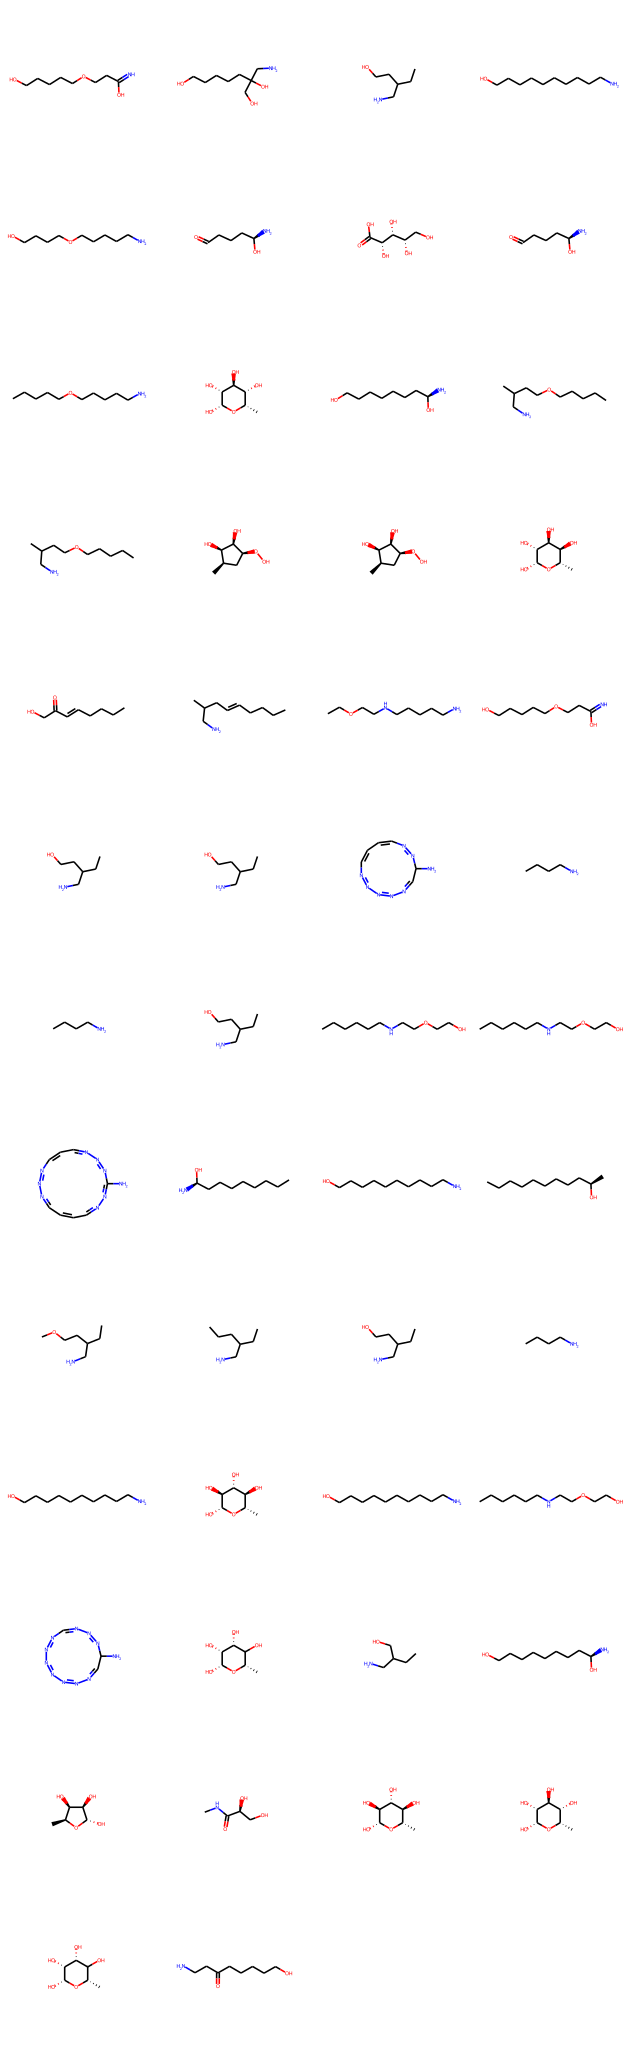

In [74]:

# Going back from vectorized form back to a readable string on Reconstructed training data
#Reconstruction

syntax_val={0:[], 1:[]}

smi_reconst_train=[]
smi_reconst_train_valid=[]

mols_reconst_train= []
mols_reconst_train_valid=[]
for id in range(len(X_train)):
  smi="".join([int_to_char[idx] for idx in np.argmax(reconst_train[id,:,:], axis=1)])
  # print(len(mol))
  smi = re.sub('!|E',"", smi)
  smi_reconst_train.append(smi)
  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_reconst_train.append(mol)
  if mol is None:
    syntax_val[0].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t invalid SMILES", sep=' ')
    # print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val[1].append(id)
    print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid Smiles", sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol)      
    except:
      print('Mol {} {}'.format(id+1, mol)) 


for item in syntax_val[1]:
  smi_reconst_train_valid.append(smi_reconst_train[item].rstrip('\n'))
  mols_reconst_train_valid.append(mols_reconst_train[item])
  print("Original Valid", smi_orig_train[item])
  print("Reconstructed valid", smi_reconst_train[item])

print(len(mols_reconst_train_valid), "Reconstructed Valid Training Samples")
Draw.MolsToGridImage(mols_reconst_train_valid, molsPerRow=4,subImgSize=(200,200))



In [ ]:

smi = "Cc1ccc(c(cccCCCCCCCCCCCCCCCCCCCCCcCcCcccccccc)cccc)c1"
print(smi)
mol = Chem.MolFromSmiles(smi)
print(mol)
mol

# **Generating New Samples from Normal Distribution with Specified Properties**

Mol 1 	 length = 17 	 invalid SMILES
N=C(O)(CO)C(CCCCO
Mol 2 	 length = 21 	 invalid SMILES
C[C@@H](O)CCC@H]CCCCO
Mol 3 	 length = 13 	 invalid SMILES
Nc1nnncnnnnnc
Mol 4 	 length = 17 	 invalid SMILES
NCCC(=c)C(=O)O)11
Mol 5 	 length = 21 	 invalid SMILES
CCC(O))CC@@](CCCCC=OO
Mol 6, invalid chemistry


RDKit ERROR: [05:04:50] SMILES Parse Error: extra open parentheses for input: 'N=C(O)(CO)C(CCCCO'
RDKit ERROR: [05:04:50] SMILES Parse Error: syntax error while parsing: C[C@@H](O)CCC@H]CCCCO
RDKit ERROR: [05:04:50] SMILES Parse Error: Failed parsing SMILES 'C[C@@H](O)CCC@H]CCCCO' for input: 'C[C@@H](O)CCC@H]CCCCO'
RDKit ERROR: [05:04:50] SMILES Parse Error: unclosed ring for input: 'Nc1nnncnnnnnc'
RDKit ERROR: [05:04:50] SMILES Parse Error: extra close parentheses while parsing: NCCC(=c)C(=O)O)11
RDKit ERROR: [05:04:50] SMILES Parse Error: Failed parsing SMILES 'NCCC(=c)C(=O)O)11' for input: 'NCCC(=c)C(=O)O)11'
RDKit ERROR: [05:04:50] SMILES Parse Error: extra close parentheses while parsing: CCC(O))CC@@](CCCCC=OO
RDKit ERROR: [05:04:50] SMILES Parse Error: Failed parsing SMILES 'CCC(O))CC@@](CCCCC=OO' for input: 'CCC(O))CC@@](CCCCC=OO'
RDKit ERROR: [05:04:50] non-ring atom 9 marked aromatic


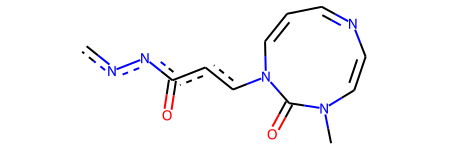

In [76]:
prop_val={}
syntax_val={}

m=None
n_mol=10
i=0
latent_samples= np.random.normal(0,1,size=(n_mol,Z_DIM))
# print(latent_samples.shape)
# predicted_prop_samples=predictor.predict(latent_samples)


#Passing it to Decoder Now
reconst_sample = decoder.predict(latent_samples)
new_mol=reconst_sample.reshape(n_mol, mol_size_x, mol_size_y) 
for id, latent_mol in enumerate(reconst_sample):
  mol="".join([int_to_char[idx] for idx in np.argmax(new_mol[id,:,:], axis=1)])
  mol = re.sub('!|E',"", mol)
  # print(i,"", mol)
  m3 = Chem.MolFromSmiles(mol, sanitize=False)
  
  if m3 is None:
    syntax_val[id]=0
    print('Mol', id+1, "\t length =",len(mol), "\t invalid SMILES", sep=' ')
    print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val[id]=1
    print(m3)
    m3
    try:
      Chem.SanitizeMol(m3)
    except:
      print('Mol {}, invalid chemistry'.format(id+1)) 
    break
m3


# syntax_val={0:[], 1:[]}

# smi_reconst_train=[]
# smi_reconst_train_valid=[]

# mols_reconst_train= []
# mols_reconst_train_valid=[]
# for id in range(len(X_train)):
#   smi="".join([int_to_char[idx] for idx in np.argmax(reconst_train[id,:,:], axis=1)])
#   # print(len(mol))
#   smi = re.sub('!|E',"", smi)
#   smi_reconst_train.append(smi)
#   mol = Chem.MolFromSmiles(smi, sanitize=True)
#   mols_reconst_train.append(mol)
#   if mol is None:
#     syntax_val[0].append(id)
#     # print('Mol', id+1, "\t length =",len(smi), "\t invalid SMILES", sep=' ')
#     # print(mol, end ='\n', sep= ' ')
#     continue
#   else:
#     syntax_val[1].append(id)
#     print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid Smiles", sep=' ', end ='\n', flush = True)
#     try:
#       Chem.SanitizeMol(mol)      
#     except:
#       print('Mol {} {}'.format(id+1, mol)) 


# for item in syntax_val[1]:
#   smi_reconst_train_valid.append(smi_reconst_train[item].rstrip('\n'))
#   mols_reconst_train_valid.append(mols_reconst_train[item])
#   print("Original Valid", smi_orig_train[item])
#   print("Reconstructed valid", smi_reconst_train[item])

# print(len(mols_reconst_train_valid), "Reconstructed Valid Training Samples")
# Draw.MolsToGridImage(mols_reconst_train_valid, molsPerRow=4,subImgSize=(200,200))




In [ ]:
# #Checking the property of molecule
# for id, latent_mol in enumerate(latent_samples):
#   # print(id)
#   e=predicted_prop_samples[id][0]<(SAS_mean_test+SAS_std_test)
#   f=predicted_prop_samples[id][0]>=(SAS_mean_test-SAS_std_test)
#   if (syntax_val[id]==1):  #Checking if all of the property values matches
#     if (e & f):
#       prop_val[id]=1
#       print("Mol {}, Property Validated".format(id+1))
#       print("Predicted Properties=")
#       print(predicted_prop_samples[id][0])
#     else:    
#       prop_val[id]=0
#       print("Mol {}, Property Invalidated".format(id+1))  
#   else:
#     print("Invalid Molecules... Property Not Checked")
#     continue